In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb 
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
#from ecgdetectors import Detectors
import pandas as pd

In [2]:
datasetdf_path = 'New data.csv'
# Read dataset into a DataFrame
datasetdf_df = pd.read_csv(datasetdf_path)

# Display the first few rows of the DataFrame
print(datasetdf_df.head())

   ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0    4759      3250.0  39.0    1   180.0   116.0    NaN  41.0  AT-6 C 5.5   
1    9278     19350.0  60.0    1     NaN     NaN    0.0   0.0  CS100    3   
2   13398     20811.0  65.0    1     NaN     NaN    1.0   2.0       CS-12   
3   11144      1160.0  55.0    0   183.0    77.0    5.0   1.0  AT-6     6   
4     399     15234.0  40.0    0     NaN    85.0    2.0   0.0   CS-12   E   

        recording_date  ... validated_by_human baseline_drift static_noise  \
0  1990-08-11 14:18:54  ...               True            NaN          NaN   
1  1992-11-03 12:04:22  ...              False            NaN          NaN   
2  1994-11-29 11:34:41  ...               True            NaN          NaN   
3  1993-10-02 07:45:26  ...               True           , v1          NaN   
4  1987-01-17 14:16:48  ...               True            NaN          NaN   

  burst_noise electrodes_problems  extra_beats  pacemaker  strat_fol

#Code

###Code

In [3]:
def collect_and_label(dataset):
    # Collect only the MI classes and the NORM classes from the dataset.
    df = pd.read_csv(dataset)
    alpha = df['scp_codes'].str.split("'").str[1].str[-2:] == 'MI'  # Collect all the MI classes.
    beta = df['scp_codes'].str.split("'").str[1] == 'NORM'  # Collect all the Normal classes.
    df = df[alpha | beta]
    df['label'] = df['scp_codes'].str.split("'").str[1]  # Create a new column 'label' containing categorical labels.

    return df

In [4]:
df_labeled = collect_and_label('New data.csv')
print(df_labeled.head())

   ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0    4759      3250.0  39.0    1   180.0   116.0    NaN  41.0  AT-6 C 5.5   
1    9278     19350.0  60.0    1     NaN     NaN    0.0   0.0  CS100    3   
2   13398     20811.0  65.0    1     NaN     NaN    1.0   2.0       CS-12   
3   11144      1160.0  55.0    0   183.0    77.0    5.0   1.0  AT-6     6   
4     399     15234.0  40.0    0     NaN    85.0    2.0   0.0   CS-12   E   

        recording_date  ... baseline_drift static_noise burst_noise  \
0  1990-08-11 14:18:54  ...            NaN          NaN         NaN   
1  1992-11-03 12:04:22  ...            NaN          NaN         NaN   
2  1994-11-29 11:34:41  ...            NaN          NaN         NaN   
3  1993-10-02 07:45:26  ...           , v1          NaN         NaN   
4  1987-01-17 14:16:48  ...            NaN          NaN         NaN   

  electrodes_problems extra_beats  pacemaker  strat_fold  \
0                 NaN         NaN        NaN      

In [5]:
label_counts = Counter(df_labeled['label'])
for label, count in label_counts.items():
    print(f"Label '{label}' has {count} records.")

Label 'NORM' has 2232 records.
Label 'IMI' has 1943 records.
Label 'ASMI' has 232 records.
Label 'PMI' has 1 records.
Label 'AMI' has 41 records.
Label 'ALMI' has 8 records.
Label 'LMI' has 1 records.


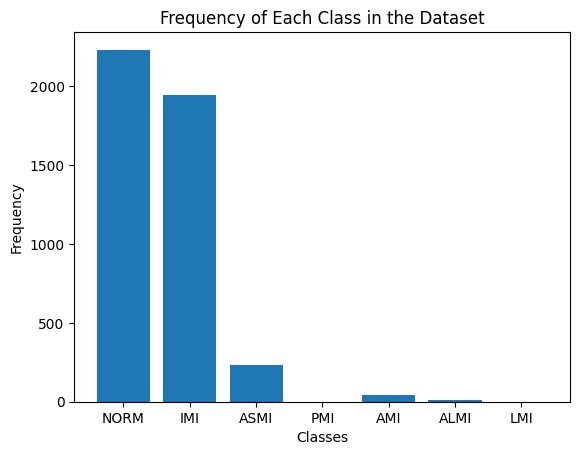

In [6]:
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class in the Dataset')
plt.show()

In [7]:
import pandas as pd

# Assuming your dataset is stored in a DataFrame called 'df'
# and the label column is named 'label'

# Filter the data to include only records with labels 'NORM' and 'IMI'
data = df_labeled[df_labeled['label'].isin(['NORM', 'IMI'])]

# Display the first few rows of the filtered data to verify
print(data.head())

   ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0    4759      3250.0  39.0    1   180.0   116.0    NaN  41.0  AT-6 C 5.5   
1    9278     19350.0  60.0    1     NaN     NaN    0.0   0.0  CS100    3   
2   13398     20811.0  65.0    1     NaN     NaN    1.0   2.0       CS-12   
3   11144      1160.0  55.0    0   183.0    77.0    5.0   1.0  AT-6     6   
4     399     15234.0  40.0    0     NaN    85.0    2.0   0.0   CS-12   E   

        recording_date  ... baseline_drift static_noise burst_noise  \
0  1990-08-11 14:18:54  ...            NaN          NaN         NaN   
1  1992-11-03 12:04:22  ...            NaN          NaN         NaN   
2  1994-11-29 11:34:41  ...            NaN          NaN         NaN   
3  1993-10-02 07:45:26  ...           , v1          NaN         NaN   
4  1987-01-17 14:16:48  ...            NaN          NaN         NaN   

  electrodes_problems extra_beats  pacemaker  strat_fold  \
0                 NaN         NaN        NaN      

In [8]:
label_counts = Counter(data['label'])
for label, count in label_counts.items():
    print(f"Label '{label}' has {count} records.")

Label 'NORM' has 2232 records.
Label 'IMI' has 1943 records.


In [9]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
import pandas as pd

def balance_and_augment(df):
    # Augment the dataset
    smote_nc = SMOTENC(categorical_features=[1], random_state=0)
    X_res, y_res = smote_nc.fit_resample(df[['ecg_id', 'filename_hr']].to_numpy(), df['label'])
    df_balanced = pd.DataFrame(X_res, columns=['ecg_id', 'filename_hr'])
    df_balanced['label'] = y_res

    return df_balanced

In [10]:
# Collecting and labeling dataset
df_labeled = collect_and_label('ptbxl_database.csv')

# Balancing and augmenting the dataset
df_balanced_and_augmented = balance_and_augment(data)

# Printing the first few rows of the resulting DataFrame
print(df_balanced_and_augmented.head())

    ecg_id                filename_hr label
0   4759.0  records500/04000/04759_hr  NORM
1   9278.0  records500/09000/09278_hr  NORM
2  13398.0  records500/13000/13398_hr  NORM
3  11144.0  records500/11000/11144_hr  NORM
4    399.0  records500/00000/00399_hr  NORM


In [11]:
label_counts = Counter(df_balanced_and_augmented['label'])
for label, count in label_counts.items():
    print(f"Label '{label}' has {count} records.")

Label 'NORM' has 2232 records.
Label 'IMI' has 2232 records.


In [12]:
df_balanced_and_augmented=df_balanced_and_augmented.sample(frac = 1 , ignore_index=True, random_state=123)

In [13]:
df_balanced_and_augmented

,ecg_id,filename_hr,label
0,7781.0,records500/07000/07781_hr,IMI
1,4036.0,records500/04000/04036_hr,NORM
2,8857.0,records500/08000/08857_hr,NORM
3,9380.0,records500/09000/09380_hr,IMI
4,14816.0,records500/14000/14816_hr,NORM
...,...,...,...
4459,18605.0,records500/18000/18605_hr,NORM
4460,18949.0,records500/18000/18949_hr,IMI
4461,18242.0,records500/18000/18242_hr,NORM
4462,15365.0,records500/15000/15365_hr,IMI


In [14]:
# Identify missing values
missing_values = df_balanced_and_augmented.isnull().sum()
print("Missing values:")
print(missing_values)  

Missing values:
ecg_id         0
filename_hr    0
label          0
dtype: int64


In [15]:
# Display the first record from the DataFrame
print(df_balanced_and_augmented.iloc[200])

ecg_id                           16073.0
filename_hr    records500/16000/16073_hr
label                               NORM
Name: 200, dtype: object


In [16]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import wfdb

# Apply Butterworth high-pass filter
def apply_highpass_filter(signal, lowcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='high')
    return filtfilt(b, a, signal)

# Function to apply high-pass filter to lead 1 at channel 0
def apply_highpass_filter_to_lead1(file_path):
    # Load ECG record
    record = wfdb.rdrecord(file_path)

    # Extract lead 1 signal (assuming it's at channel 0)
    lead_1_signal = record.p_signal[:, 0]

    # Sampling frequency
    fs = record.fs

    # Apply high-pass filter
    lowcut = 0.5  # Adjust cutoff frequency as needed
    filtered_lead_1_signal = apply_highpass_filter(lead_1_signal, lowcut, fs)

    return filtered_lead_1_signal

# Assuming 'filename_hr' contains file paths to ECG signals
file_paths = df_balanced_and_augmented['filename_hr']

# Apply high-pass filter to lead 1 at channel 0 for each file
filtered_signals = []
for file_path in file_paths:
    filtered_signal = apply_highpass_filter_to_lead1(file_path)
    filtered_signals.append(filtered_signal)

# Add filtered signals to DataFrame
df_balanced_and_augmented['filtered_lead_1_channel_0'] = filtered_signals

# Display DataFrame with filtered signals
print(df_balanced_and_augmented)


       ecg_id                filename_hr label  \
0      7781.0  records500/07000/07781_hr   IMI   
1      4036.0  records500/04000/04036_hr  NORM   
2      8857.0  records500/08000/08857_hr  NORM   
3      9380.0  records500/09000/09380_hr   IMI   
4     14816.0  records500/14000/14816_hr  NORM   
...       ...                        ...   ...   
4459  18605.0  records500/18000/18605_hr  NORM   
4460  18949.0  records500/18000/18949_hr   IMI   
4461  18242.0  records500/18000/18242_hr  NORM   
4462  15365.0  records500/15000/15365_hr   IMI   
4463   4755.0  records500/04000/04755_hr   IMI   

                              filtered_lead_1_channel_0  
0     [-0.05535706432148732, -0.055705980314489374, ...  
1     [-0.017722321193429806, -0.017834025117279443,...  
2     [-0.037288157163053365, -0.037523184698260166,...  
3     [-0.02261151421908207, -0.0227540347633655, -0...  
4     [-0.025732273877728324, -0.02587018510813184, ...  
...                                                

In [17]:
import matplotlib.pyplot as plt
from tensorflow import data 
import wfdb as sig
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras import regularizers
from sklearn.model_selection import train_test_split

In [18]:
def preprocess(dat):
    data_dir = list(dat['filename_hr'])
    data_signal = map(read_signal , data_dir)
    data_signal = list(data_signal)
    data_signal = np.array(data_signal)
    data_dict = {'NORM' : 0 , 'IMI': 1  }
    encoded_label = dat['label'].map(data_dict)
    return np.array(data_signal)  , np.array(encoded_label)

In [19]:
from sklearn.model_selection import train_test_split

# Splitting data into train and (validation + test) sets
train, val_test = train_test_split(df_balanced_and_augmented, train_size=0.7, random_state=1002)

# Splitting (validation + test) into validation and test sets
validation, test = train_test_split(val_test, test_size=0.5, random_state=1002)

# Printing the sizes of train, validation, and test sets
print("Train size:", len(train))
print("Validation size:", len(validation))
print("Test size:", len(test))

Train size: 3124
Validation size: 670
Test size: 670


In [20]:
print(train.shape)
print(validation.shape)
print(test.shape)

(3124, 4)
(670, 4)
(670, 4)


In [21]:
def read_signal(record):
    tes = sig.rdrecord(record,sampfrom=0 , sampto=5000)
    signal = tes.__dict__['p_signal'][::,0]
    return signal

In [22]:
X_train , y_train = preprocess(train)
X_valid , y_valid = preprocess(validation)
X_test  , y_test  = preprocess(test) 

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(3124, 5000)
(3124,)
(670, 5000)
(670,)
(670, 5000)
(670,)


In [24]:
# Reshape input data to add the timestep dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(3124, 5000, 1)
(3124,)
(670, 5000, 1)
(670,)
(670, 5000, 1)
(670,)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint

# Function to build the CRNN model
def build_crnn_model(input_shape, num_classes):
    model = Sequential()
    
    # CNN layers
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    # LSTM layer
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Flatten before dense layer
    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Define input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = 2  # Two classes: normal and abnormal

# Build the CRNN model
crnn_model = build_crnn_model(input_shape, num_classes)

# Compile the model with a lower learning rate
crnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

# Print model summary
crnn_model.summary()

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_sparse_categorical_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
batch_size = 32
epochs = 20  # Increased number of epochs

history = crnn_model.fit(X_train, y_train, 
                         batch_size=batch_size, 
                         epochs=epochs, 
                         validation_data=(X_valid, y_valid),
                         callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = crnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 4996, 32)            │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4996, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 2498, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2498, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 2496, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2496, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 1248, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1248, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1248, 64)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1248, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 79872)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      10,223,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,263,810 (39.15 MB)

 Trainable params: 10,263,618 (39.15 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.7375 - sparse_categorical_accuracy: 0.5431
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.52239, saving model to best_model.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 56s 537ms/step - loss: 0.7370 - sparse_categorical_accuracy: 0.5437 - val_loss: 0.8431 - val_sparse_categorical_accuracy: 0.5224
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 0.5505 - sparse_categorical_accuracy: 0.7213
Epoch 2: val_sparse_categorical_accuracy improved from 0.52239 to 0.52537, saving model to best_model.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 512ms/step - loss: 0.5506 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.7470 - val_sparse_categorical_accuracy: 0.5254
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 0.4404 - sparse_categorical_accuracy: 0.7992
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.52537
98/98 ━━━━━━━━━━━━━━━━━━━━ 48s 490ms/step - loss: 0.4404 - sparse_categorical_accuracy: 0.

In [31]:
# Predict probabilities on the test set
y_pred_proba = crnn_model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step


In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, f1_score

# Define the threshold search range
thresholds = np.linspace(0, 1, 1000)

# Initialize variables to store best threshold and corresponding metrics
best_threshold = None
best_metric_sum = float('-inf')  # We want to maximize this sum

# Loop through each threshold and calculate corresponding metrics
for threshold in thresholds:
    y_pred_thresholded = (y_pred_proba[:, 1] > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresholded)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    # Calculate the sum of true positives and true negatives while minimizing false positives and false negatives
    metric_sum = TP + TN - FP - FN
    
    # Update best threshold and best metric sum if a better threshold is found
    if metric_sum > best_metric_sum:
        best_metric_sum = metric_sum
        best_threshold = threshold

# Print the best threshold and corresponding metrics
print("Best Threshold:", best_threshold)
print("Best Metric Sum (TP + TN - FP - FN):", best_metric_sum)

# Convert predicted probabilities to class labels using the optimal threshold
y_pred_optimal = (y_pred_proba[:, 1] > best_threshold).astype(int)

# Compute confusion matrix using the optimal threshold
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

# Extract TP, TN, FP, FN using the optimal threshold
TP_optimal = cm_optimal[1, 1]
TN_optimal = cm_optimal[0, 0]
FP_optimal = cm_optimal[0, 1]
FN_optimal = cm_optimal[1, 0]

# Print the number of TP, TN, FP, FN using the optimal threshold
print("True Positives with Optimal Threshold:", TP_optimal)
print("True Negatives with Optimal Threshold:", TN_optimal)
print("False Positives with Optimal Threshold:", FP_optimal)
print("False Negatives with Optimal Threshold:", FN_optimal)

# Compute precision, F1 score, sensitivity (recall), and specificity
precision_optimal = precision_score(y_test, y_pred_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)
sensitivity_optimal = TP_optimal / (TP_optimal + FN_optimal)
specificity_optimal = TN_optimal / (TN_optimal + FP_optimal)

# Print precision, F1 score, sensitivity (recall), and specificity
print("Precision with Optimal Threshold:", precision_optimal)
print("F1 Score with Optimal Threshold:", f1_optimal)
print("Sensitivity (Recall) with Optimal Threshold:", sensitivity_optimal)
print("Specificity with Optimal Threshold:", specificity_optimal)

Best Threshold: 0.8188188188188188
Best Metric Sum (TP + TN - FP - FN): 308
True Positives with Optimal Threshold: 254
True Negatives with Optimal Threshold: 235
False Positives with Optimal Threshold: 90
False Negatives with Optimal Threshold: 91
Precision with Optimal Threshold: 0.7383720930232558
F1 Score with Optimal Threshold: 0.7373004354136431
Sensitivity (Recall) with Optimal Threshold: 0.736231884057971
Specificity with Optimal Threshold: 0.7230769230769231


Confusion Matrix with Optimal Threshold:
[[235  90]
 [ 91 254]]


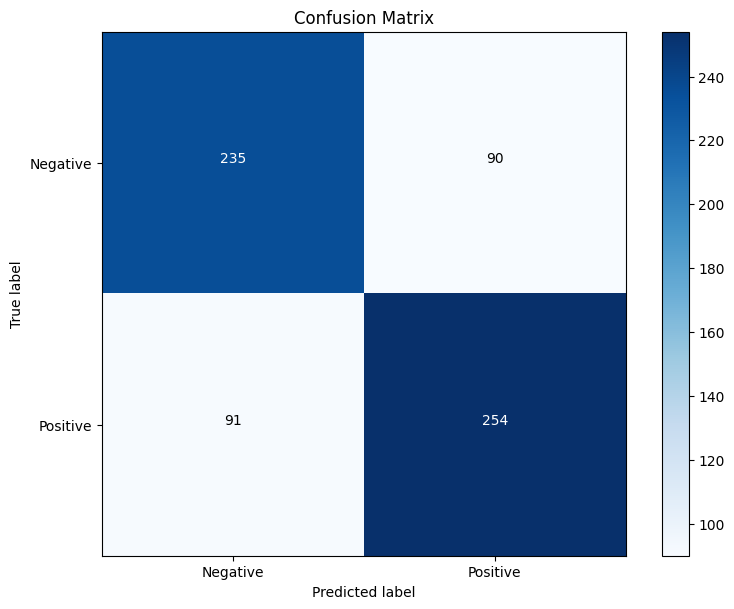

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, f1_score
import matplotlib.pyplot as plt
import itertools

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Assuming you have already computed the optimal threshold metrics
best_threshold = 0.8188188188188188
y_pred_optimal = (y_pred_proba[:, 1] > best_threshold).astype(int)  # Assuming y_pred_proba is available

# Compute confusion matrix using the optimal threshold
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

# Define class labels
classes = ['Negative', 'Positive']  # Replace with your actual class labels

# Print confusion matrix details
print("Confusion Matrix with Optimal Threshold:")
print(cm_optimal)

# Plot confusion matrix for optimal threshold
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_optimal, classes)
plt.show()


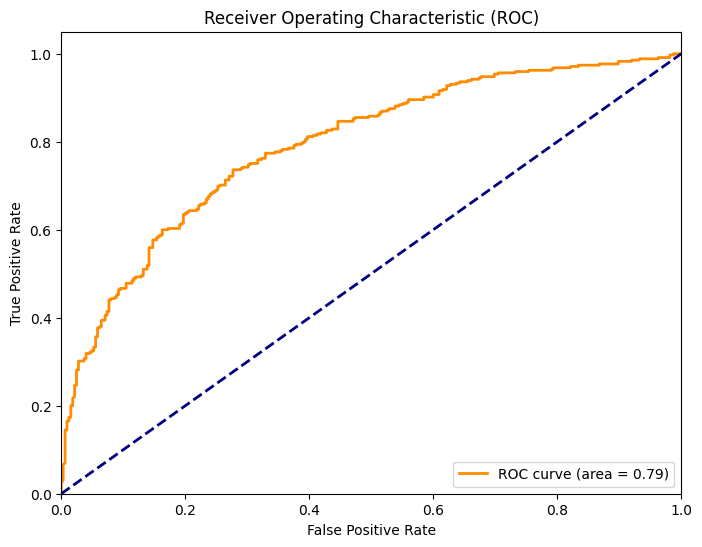

In [46]:

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step


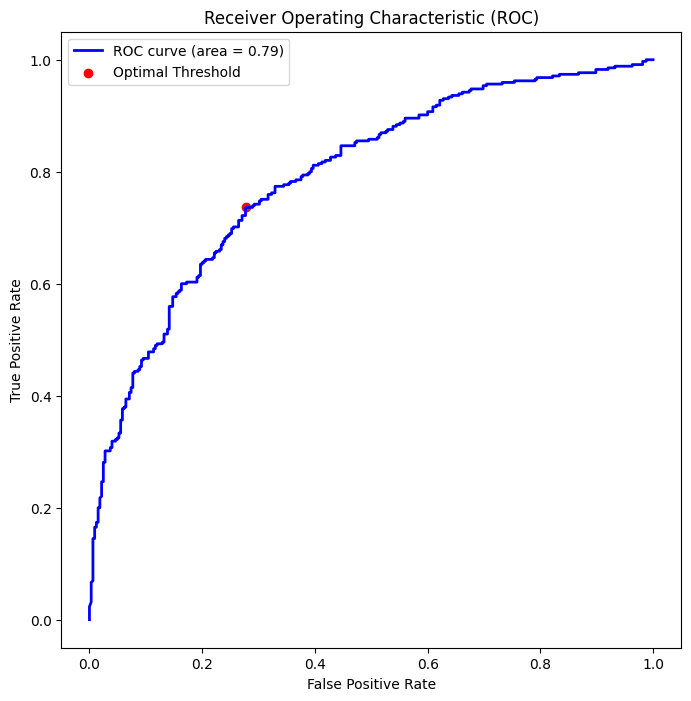

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have already computed y_pred_proba using your CRNN model
y_pred_proba = crnn_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba[:, 1])  # Assuming y_test is binary (0 or 1)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Mark optimal threshold point on ROC curve
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_threshold_index]
plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='red', marker='o', label='Optimal Threshold')
plt.legend()

plt.show()
